In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_digits
from numpy import linalg as LA
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from numpy import linalg as LA
from copy import deepcopy
from numba import jit, cuda
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import sem
from scipy.spatial.distance import cdist
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
def compute_margin(K, y, alpha, b, norm_w, model):
    margin = []
    if model == "RP-IMA dual":
        for i in range(y.shape[0]):
            margin.append(y[i]*(np.dot(alpha * y, K[:, i]))/norm_w)
    elif model == "ELM dual": 
        for i in range(y.shape[0]):
            margin.append(y[i]*(np.dot(alpha, K[:, i]))/norm_w)
    if min(margin) >= 0:
        return min(margin)
    return 0

In [3]:
def sigmoid(z):
    sigmoid = 1.0/(1.0 + np.exp(-z))
    return sigmoid 
    
class RP_IMA_dual(BaseEstimator, ClassifierMixin):

    def __init__(self, n_neurons, kernel='rbf', delta_margin=10e-3, gamma='scale', degree=3,
                eta=0.1, max_fmp_updates=100000, IMA_iterations=100,
                regularization_term=0, seed = 0):
        self.n_neurons = n_neurons   # number of hidden neurons
        self.kernel = kernel         # kernel type
        self.gamma = gamma           # kernel param for RBF
        self.degree = degree         # degree of polynomial kernel
        self.delta_margin = delta_margin    # minimum margin increment
        self.eta = eta
        self.max_fmp_updates = max_fmp_updates
        self.IMA_iterations = IMA_iterations
        self.regularization_term = regularization_term # regularization parameter
        self.threshold = 0.1
        self.iterations = 1
        self.seed = seed

    # apply linear kernel
    @staticmethod
    @jit(target_backend='cuda')
    def linear_kernel(H):
        return np.dot(H, np.transpose(H))

    # apply plynomial kernel
    @staticmethod
    @jit(target_backend='cuda')
    def polynomial_kernel(H, degree):
        return (np.dot(H, np.transpose(H)))**degree

    @staticmethod
    def silverman_rule(data):
        n = len(data)
        std_data = np.std(data)
        IQR = np.subtract(*np.percentile(data, [75, 25]))
        h = 0.9 * np.min([std_data, IQR/1.34]) * n**(-0.2)
        return h

    @staticmethod
    def rbf_kernel(H, gamma):
        pairwise_dists = cdist(H, H, 'euclidean')
        K = np.exp((-pairwise_dists**2)/(gamma**2))
        return K


    # Dual algorithm to training the fixed geometric mergin perceptron
    @staticmethod
    @jit(target_backend='cuda')
    def dual_FMP_algorithm(K, y, alpha, b, eta, fixed_margin, max_fmp_updates):
        stop = False
        norm_w=0              # norm of w vector
        fmp_epochs=0          # number of fmp epochs
        fmp_norm_updates = 0  # number of updates of the norm of w

        # Cálculo de ||w||:
        norm_w= np.sqrt((alpha * y) @ (K @ (alpha * y)))

        while True:
            # Checking stop condition
            if stop:
                convergence = 1
                return convergence, fmp_norm_updates, fmp_epochs, norm_w, alpha, b
            elif fmp_norm_updates > max_fmp_updates:
                convergence = 0
                return convergence, fmp_norm_updates, fmp_epochs, norm_w, alpha, b
            else:
                error = False
                # subtract delta from alpha_i values before every new perceptron iteration ,
                # making sure that the property alpha_i >= 0 is respected.
                #for i in range(X.shape[0]):
                #    self.alpha[i] = self.alpha[i] - self.delta
                #    if self.alpha[i] < 0:
                #        self.alpha[i] = 0
                # Loop:
                #Delta_b = 0
                for i in range(K.shape[0]):
                    Delta=0
                    # Checking the margin criterion
                    if((y[i] * np.dot(alpha, y * K[:, i])+b) <= fixed_margin * norm_w):
                        fmp_norm_updates += 1
                        # alpha update:
                        previous_alpha_y = alpha[i]*y[i]
                        if norm_w != 0:
                            alpha = alpha * (1 - (eta*fixed_margin)/norm_w)
                        alpha[i] += eta
                        Delta = alpha[i]*y[i] - previous_alpha_y
                        #Delta_b += Delta
                        # norm update:
                        norm_w = sqrt(norm_w**2 + Delta * np.dot(alpha, y * K[i, :]))
                        error = True
                #b += Delta_b
                norm_w= np.sqrt((alpha * y) @ (K @ (alpha * y)))
                if not error:
                    stop = True
                fmp_epochs+=1


    def IM_algorithm(self, X, y):
        #alpha = np.array([random.uniform(0, 1) for i in range(X.shape[0])]) #
        alpha = np.ones((X.shape[0])) * 0.00000001
        self.fixed_margin = 0
        t = 0
        convergence = 1
        self.updates = 0
        iterations = 0
        self.b=0  # bias term
        # perceptron kernel matrix
        if self.kernel == 'linear':
            self.K = self.linear_kernel(X) + np.identity(X.shape[0]) * self.regularization_term
        elif self.kernel == 'poly':
            self.K = self.polynomial_kernel(X, self.degree) + np.identity(X.shape[0]) * self.regularization_term
        elif self.kernel == 'rbf':
            self.gamma = self.silverman_rule(X)
            self.K = self.rbf_kernel(X, self.gamma) + np.identity(X.shape[0]) * self.regularization_term
        self.margin = np.zeros(self.IMA_iterations+1)
        while convergence == 1 and t < self.IMA_iterations:
            gamma1 = []
            gamma2 = []
            #print(f'{self.fixed_margin:1.30f}')
            convergence, updates_, iterations, norm_w, alpha, b = self.dual_FMP_algorithm(self.K, y, alpha, self.b, self.eta, self.fixed_margin, self.max_fmp_updates)
            self.updates += updates_
            if convergence == 1 or t==0:
                self.alpha = deepcopy(alpha)
                self.b = 0
                self.norm_w = norm_w
                for i in range(0, y.shape[0]):
                    aux = np.dot(self.alpha * y, self.K[:, i])
                    if y[i] == 1:
                        gamma1.append(y[i]*((aux + self.b)/self.norm_w))
                    else:
                        gamma2.append(y[i]*((aux + self.b)/self.norm_w))
                gamma1 = np.array(gamma1)
                gamma2 = np.array(gamma2)
                gamma1 = gamma1[gamma1>=0]
                gamma2 = gamma2[gamma2>=0]
                min_gamma1 = 0
                min_gamma2 = 0
                if len(gamma1) > 0:
                    min_gamma1 = min(gamma1)
                if len(gamma2) > 0:
                    min_gamma2 = min(gamma2)
                self.fixed_margin = max([(min_gamma1 + min_gamma2)/2, (1+self.delta_margin)*self.fixed_margin])
                t += 1
                self.margin[t] = (compute_margin(self.K, y, self.alpha, 0, self.norm_w, "RP-IMA dual"))
        self.iterations = t


    def fit(self, X, y):
        # 1 - Adding polarization term
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        n = X_new.shape[1]
        # 2 - Geração de pesos aleatórios
        random.seed(self.seed)
        self.Z = np.array([random.uniform(-0.1, 0.1) for i in range(n*self.n_neurons)]).reshape(n, self.n_neurons)
        # 3 - Aplicação da função de ativação
        self.H = sigmoid(np.dot(X_new, self.Z))
        # 4 - IMA Dual:
        self.y_train = y
        self.IM_algorithm(self.H, y)
        # Cálculo do vetor beta para kernel linear
        if self.kernel == 'linear':
            for i in range(0, y.shape[0]):
                self.beta = np.dot(self.alpha * y, self.H)
        return self.margin
                

    def predict(self, X):
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        H_ = sigmoid(np.dot(X_new, self.Z))

        if self.kernel == 'linear':
            y_predicted = np.dot(H_, self.beta)
        elif self.kernel == 'poly':
            y_predicted = np.zeros(X.shape[0])
            for j in range(X.shape[0]):
                for i in range(X.shape[0]):
                    y_predicted[j] += self.alpha[i] * self.y_train[i] * (np.dot(self.H[i], H_[j]) + 1)**self.degree
        elif self.kernel == 'rbf':
            pairwise_dists = cdist(H_, self.H, 'euclidean')
            K = np.exp((-pairwise_dists**2)/(self.gamma**2))
            y_predicted = K @ (self.alpha * self.y_train) 
            y_predicted += self.b
        y_predicted[y_predicted>=0] = 1
        y_predicted[y_predicted<0] = -1
        return y_predicted

In [4]:
class ELM_dual(BaseEstimator, ClassifierMixin):
         
    def __init__(self, n_neurons, kernel='rbf', regularization_term= 0, degree=3, seed = 0):
        self.n_neurons = n_neurons
        self.kernel = kernel
        self.degree = degree
        self.regularization_term = regularization_term
        self.iterations = 1
        self.seed = seed
        
    # apply linear kernel
    @staticmethod
    @jit(target_backend='cuda')
    def linear_kernel(H):
        return np.dot(H, np.transpose(H))

    # apply plynomial kernel
    @staticmethod
    @jit(target_backend='cuda')
    def polynomial_kernel(H, degree):
        return (np.dot(H, np.transpose(H)))**degree

    @staticmethod
    def silverman_rule(data):
        n = len(data)
        std_data = np.std(data)
        IQR = np.subtract(*np.percentile(data, [75, 25]))
        h = 0.9 * np.min([std_data, IQR/1.34]) * n**(-0.2)
        return h

    @staticmethod
    def rbf_kernel(H, gamma):
        pairwise_dists = cdist(H, H, 'euclidean')
        K = np.exp((-pairwise_dists**2)/(gamma**2))
        return K
               
    def fit(self, X, y):
        # 1 - Adding polarization term 
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        n = X_new.shape[1]
        # 2 - Geração de pesos aleatórios
        random.seed(self.seed)
        self.Z = np.array([random.uniform(-0.1, 0.1) for i in range(n*self.n_neurons)]).reshape(n, self.n_neurons)
        # 3 - Aplicação da função de ativação
        self.H = sigmoid(np.dot(X_new, self.Z))
        # 4 - Aplicação do kernel
        if self.kernel == 'linear':
            self.K = self.linear_kernel(self.H)
        elif self.kernel == 'poly':
            self.K = self.polynomial_kernel(self.H, self.degree)
        elif self.kernel == 'rbf':
            self.gamma = self.silverman_rule(self.H)
            self.K = self.rbf_kernel(self.H, self.gamma) + np.identity(self.H.shape[0]) * self.regularization_term
        # 5 - Cálculo de alpha:
        self.alpha = np.dot(np.linalg.pinv(self.K), y)
        # 6 Cálculo do vetor beta
        if self.kernel == 'linear':
            self.beta = np.dot(np.transpose(self.H), self.alpha)
        self.norm_w = np.sqrt(self.alpha @ (self.K @ self.alpha))
            
    def predict(self, X):
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        H_ = sigmoid(np.dot(X_new, self.Z))
        if self.kernel == 'linear':
            y_predicted = np.dot(H_, self.beta)
        elif self.kernel == 'poly':
            y_predicted = np.zeros(X.shape[0])
            for j in range(H_.shape[0]):
                for i in range(self.H.shape[0]):
                    y_predicted[j] += self.alpha[i] * (np.dot(self.H[i], H_[j]) + 1)**self.degree
        elif self.kernel == 'rbf':
            pairwise_dists = cdist(H_, self.H, 'euclidean')
            K = np.exp((-pairwise_dists**2)/(self.gamma**2))
            y_predicted = K @ self.alpha
        y_predicted[y_predicted>=0] = 1
        y_predicted[y_predicted<0] = -1
        return y_predicted

In [5]:
def plot_decision_border(X, y, clf, fig, pos, title):
    ax = fig.add_subplot(pos)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-0.03, X[:, 0].max()+0.03
    min2, max2 = X[:, 1].min()-0.03, X[:, 1].max()+0.03
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.001)
    x2grid = np.arange(min2, max2, 0.001)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    #grid = normalizer.transform(grid)
    # make predictions for the grid
    yhat=clf.predict(grid)
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='RdBu', alpha=0.7)
    # create scatter plot for samples from each class
    plt.scatter(X[:, 0], X[:, 1], cmap='RdBu', c=y, edgecolor='black')
    # show the plot
    plt.title(title, fontweight="bold")  

In [6]:
def plots(X, y, n_neurons, eta=0.1, reg_term=0):
    X = preprocessing.normalize(X, axis=0)
    seed = random.randint(0,100)
    clf1 = RP_IMA_dual(n_neurons, eta=eta, max_fmp_updates=10000, IMA_iterations=20,
         regularization_term=reg_term, seed = seed)
    clf1.fit(X, y)

    clf2 = ELM_dual(n_neurons, seed = seed, regularization_term=reg_term)
    clf2.fit(X, y)
    fig = plt.figure(figsize=(12,5))
    plot_decision_border(X, y, clf2, fig, 121, "Borda de decisão gerada pelo ELM-dual")
    plot_decision_border(X, y, clf1, fig, 122, "Borda de decisão gerada pelo RP-IMA dual" )
    

In [7]:
def plot_margin_evolution(m):
    avg_margins = []
    sem_margins = []
    for i in range(len(m[0])):
        margins = []
        for j in range(len(m)):
            margins.append(m[j][i]) 
        avg_margins.append(np.mean(margins))
        sem_margins.append(sem(margins))
    x = np.array(range(len(avg_margins)))
    plt.figure(1)
    plt.plot(x, avg_margins)
    plt.grid()
    plt.figure(2)
    plt.errorbar(x, avg_margins, sem_margins, color = 'blue', marker='s', capsize=5)
    plt.xlabel("IMA Iterations")
    plt.ylabel("Margin Value")
    plt.xticks(np.linspace(0, 20, 21))
    plt.grid()

In [8]:
def results(X, y, p, lambda_param=0.01):
    n_splits = 10
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    accuracy_RP_IMA_dual = np.zeros(n_splits)
    train_accuracy_RP_IMA_dual = np.zeros(n_splits)
    accuracy_ELM_dual = np.zeros(n_splits)
    margin_RP_IMA_dual = np.zeros(n_splits)
    margin_ELM_dual = np.zeros(n_splits)
    auc_RP_IMA_dual = np.zeros(n_splits)
    auc_ELM_dual = np.zeros(n_splits)
    train_accuracy_ELM_dual = np.zeros(n_splits)
    margins=[]
    seed = [10, 22, 52, 59, 1, 21, 99, 85, 74, 69]
    X = preprocessing.normalize(X, axis=0)
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    i = 0
    for train_indices, test_indices in k_fold.split(X, y):
        clf = RP_IMA_dual(n_neurons=p, eta=0.1, regularization_term=lambda_param, delta_margin=10^-3, IMA_iterations=20, max_fmp_updates=100000, seed=seed[i])
        margin = clf.fit(X[train_indices], y[train_indices])
        margins.append(margin)
        y_hat = clf.predict(X[test_indices])
        K = clf.K
        train_accuracy_RP_IMA_dual[i] = accuracy_score(y[train_indices], clf.predict(X[train_indices])) 
        auc_RP_IMA_dual[i] = roc_auc_score(y[test_indices], y_hat)
        accuracy_RP_IMA_dual[i] = accuracy_score(y[test_indices], y_hat)
        margin_RP_IMA_dual[i] = compute_margin(K, y[train_indices], clf.alpha, clf.b, clf.norm_w, "RP-IMA dual")
        
        
        clf2 = ELM_dual(p, seed=seed[i], regularization_term=lambda_param)
        clf2.fit(X[train_indices], y[train_indices])
        K = clf.K
        train_accuracy_ELM_dual[i] = accuracy_score(y[train_indices], clf.predict(X[train_indices])) 
        y_hat = clf2.predict(X[test_indices])
        auc_ELM_dual[i] = roc_auc_score(y[test_indices], y_hat)
        accuracy_ELM_dual[i] = accuracy_score(y[test_indices], y_hat)
        margin_ELM_dual[i] = compute_margin(K, y[train_indices], clf2.alpha, 0, clf2.norm_w, "ELM dual")
        i +=1
    
    print(f"*********** Resultado IM ELM_dual com {p} neurônios na camada escondida **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_RP_IMA_dual.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_RP_IMA_dual.std()))
    print("Acc: " + '{:.4f}'.format(accuracy_RP_IMA_dual.mean()) + "+/-" + '{:.4f}'.format(accuracy_RP_IMA_dual.std()))
    print("Margin: " + '{:.8f}'.format(margin_RP_IMA_dual.mean()) + "+/-" + '{:.8f}'.format(margin_RP_IMA_dual.std()))
    print("AUC: " + '{:.4f}'.format(auc_RP_IMA_dual.mean()) + "+/-" + '{:.4f}'.format(auc_RP_IMA_dual.std()))
    #print(f"IMA iterations: {iterations_IMA}")

    print(f"*********** Resultado ELM_dual com {p} neurônios na camada escondida **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_ELM_dual.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_ELM_dual.std()))
    print("Acc: " + '{:.4f}'.format(accuracy_ELM_dual.mean()) + "+/-" + '{:.4f}'.format(accuracy_ELM_dual.std()))
    print("Margin: " + '{:.14f}'.format(margin_ELM_dual.mean()) + "+/-" + '{:.14f}'.format(margin_ELM_dual.std()))
    print("AUC: " + '{:.4f}'.format(auc_ELM_dual.mean()) + "+/-" + '{:.4f}'.format(auc_ELM_dual.std()))
    return margins

*********** Resultado IM ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 0.9990+/-0.0030
Margin: 0.07561169+/-0.00577819
AUC: 0.9990+/-0.0030
*********** Resultado ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 0.9990+/-0.0030
Margin: 0.02851067175711+/-0.00104558647353
AUC: 0.9990+/-0.0030


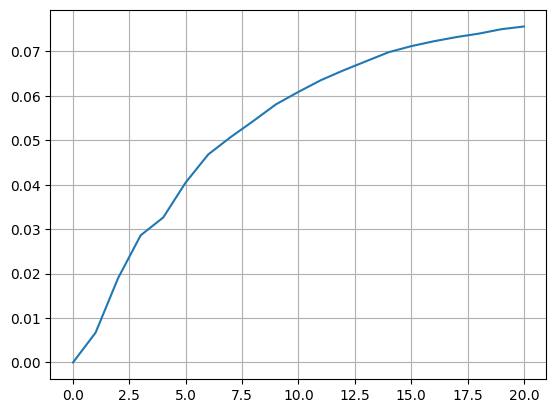

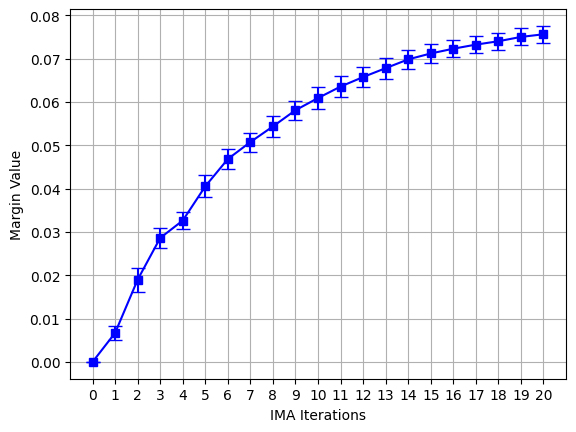

In [9]:
spirals_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
m = results(X, y, 100)
plot_margin_evolution(m)

*********** Resultado IM ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 1.0000+/-0.0000
Margin: 0.17925643+/-0.00279554
AUC: 1.0000+/-0.0000
*********** Resultado ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 1.0000+/-0.0000
Margin: 0.07584399751187+/-0.00540708045418
AUC: 1.0000+/-0.0000


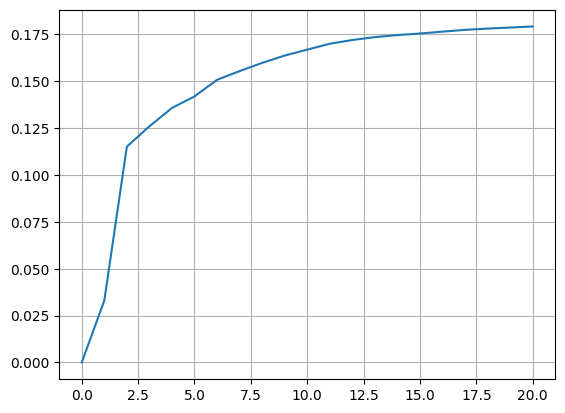

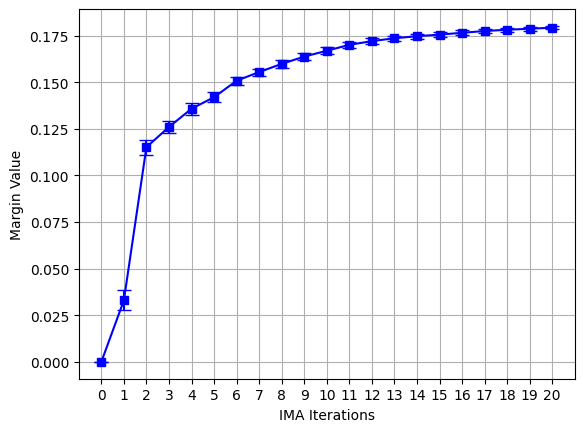

In [10]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, factor=0.4, noise=0.07)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)
plot_margin_evolution(m)

*********** Resultado IM ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 0.9970+/-0.0046
Margin: 0.15120497+/-0.00892348
AUC: 0.9970+/-0.0046
*********** Resultado ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 0.9980+/-0.0040
Margin: 0.06509581391975+/-0.00367519535242
AUC: 0.9980+/-0.0040


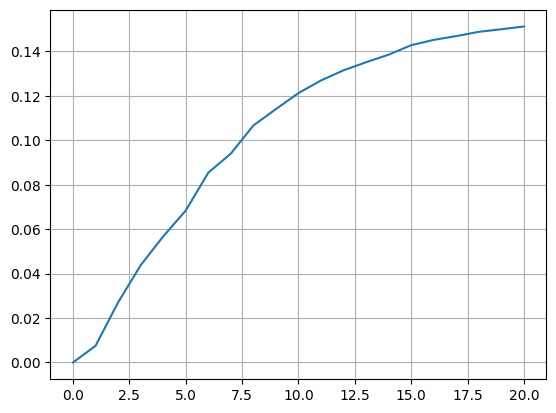

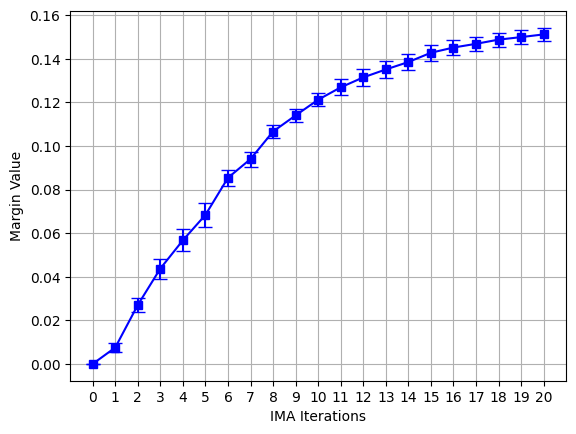

In [11]:
from sklearn.datasets import make_blobs
centers = [[-2,2],[-2,-2],[2,-2],[2,2]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6, random_state=100)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)
plot_margin_evolution(m)

*********** Resultado IM ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 0.9990+/-0.0030
Margin: 0.17112911+/-0.01148348
AUC: 0.9990+/-0.0030
*********** Resultado ELM_dual com 100 neurônios na camada escondida **************
Acc train: 1.0000+/-0.0000
Acc: 1.0000+/-0.0000
Margin: 0.10496427801311+/-0.01029992003850
AUC: 1.0000+/-0.0000


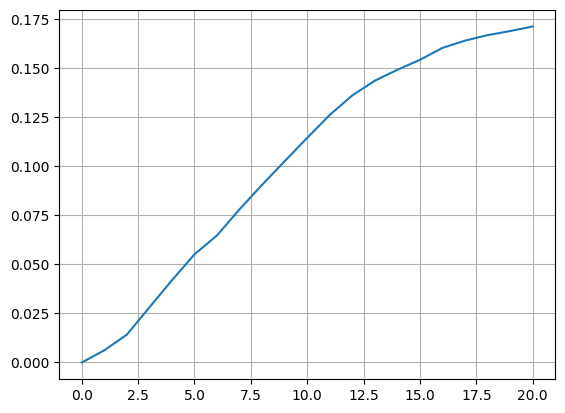

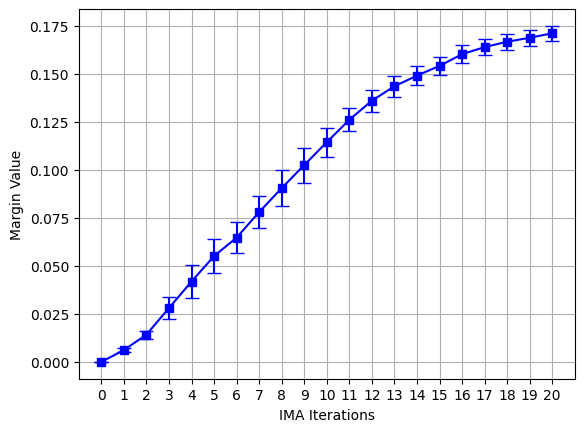

In [17]:
from sklearn.datasets import make_blobs
centers = [[-2,0],[2,0]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)
plot_margin_evolution(m)

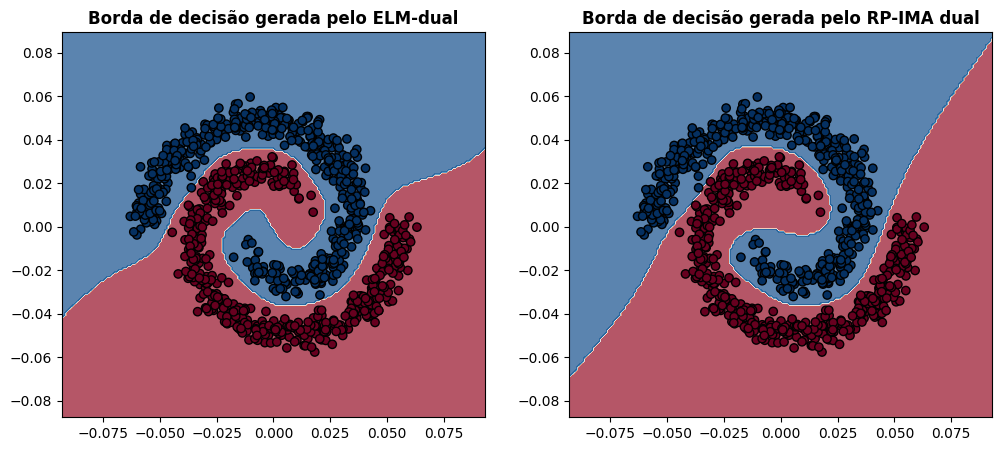

In [18]:
spirals_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
plots(X, y, 100, eta=0.1, reg_term=0.01)

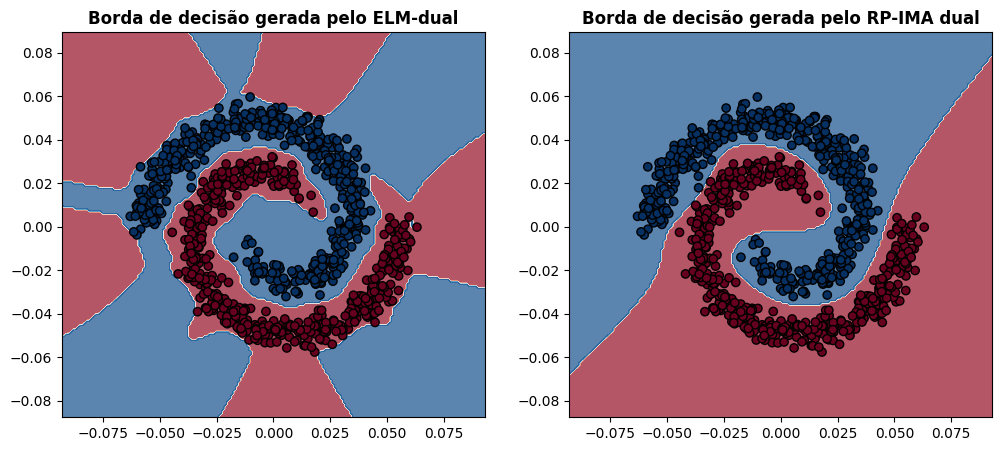

In [25]:
spirals_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
plots(X, y, 100, eta=0.1, reg_term=0)

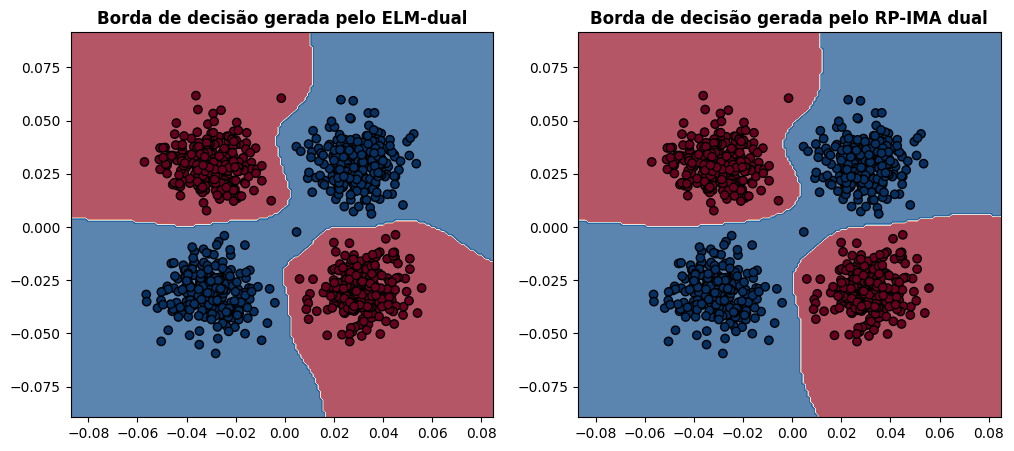

In [19]:
from sklearn.datasets import make_blobs
centers = [[-2,2],[-2,-2],[2,-2],[2,2]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6, random_state=100)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=0.01)

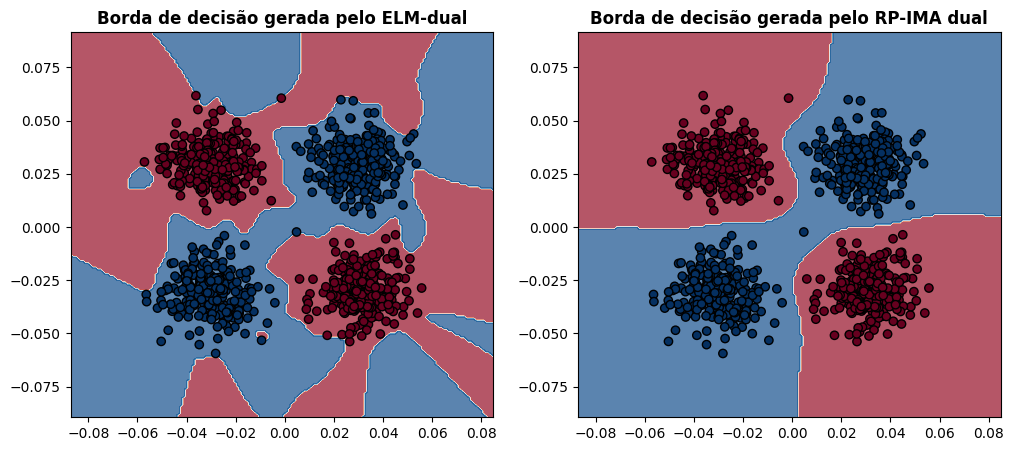

In [26]:
from sklearn.datasets import make_blobs
centers = [[-2,2],[-2,-2],[2,-2],[2,2]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6, random_state=100)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=0)

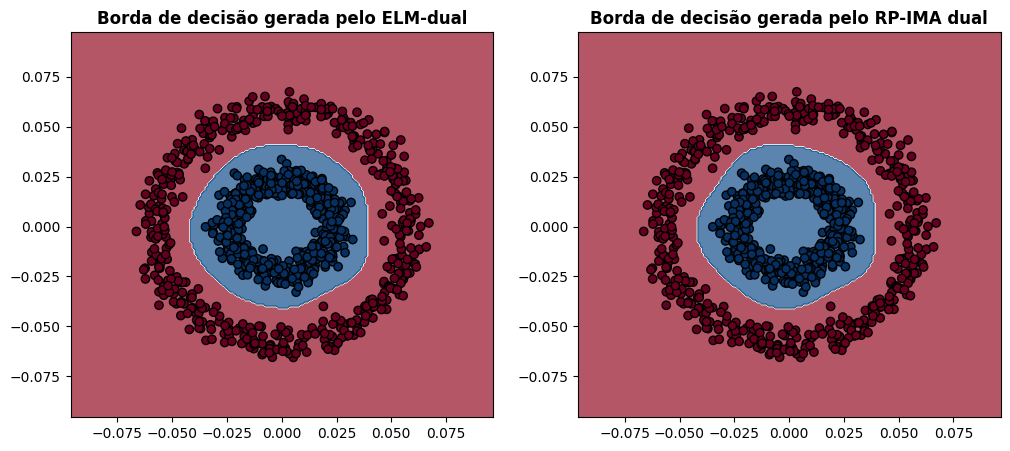

In [20]:
X, y = datasets.make_circles(n_samples=1000, factor=0.4, noise=0.07)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=0.01)

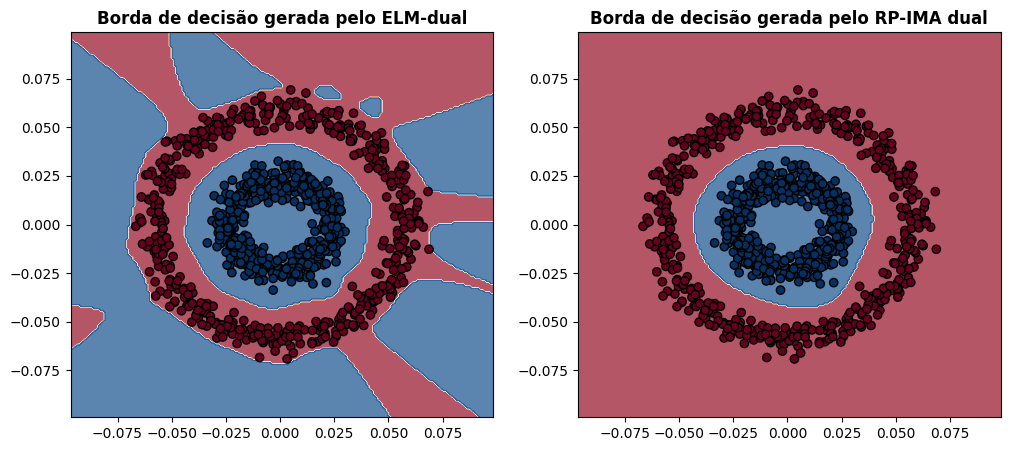

In [27]:
X, y = datasets.make_circles(n_samples=1000, factor=0.4, noise=0.07)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=0)

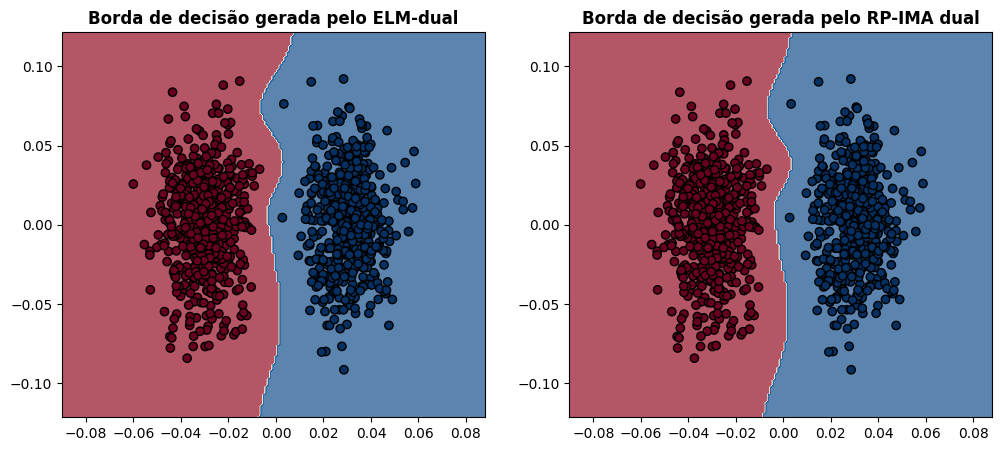

In [24]:
from sklearn.datasets import make_blobs
centers = [[-2,0],[2,0]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=0.01)

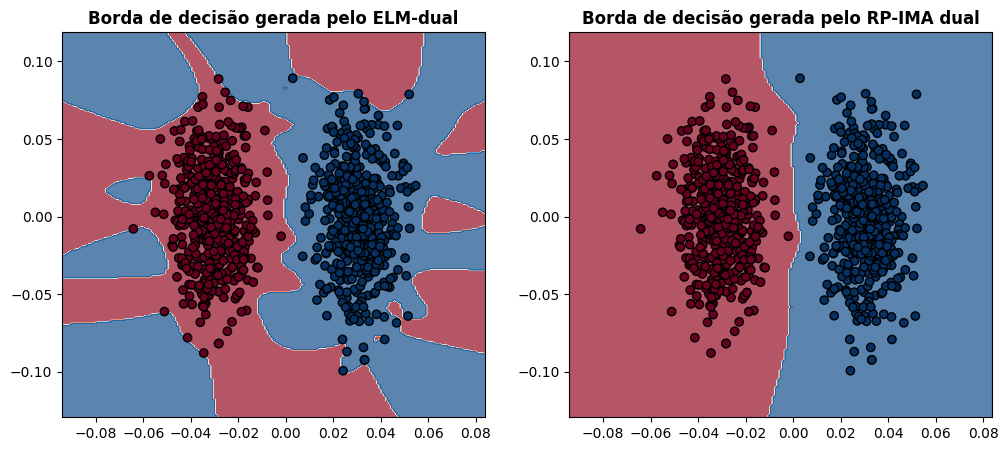

In [30]:
from sklearn.datasets import make_blobs
centers = [[-2,0],[2,0]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=0)

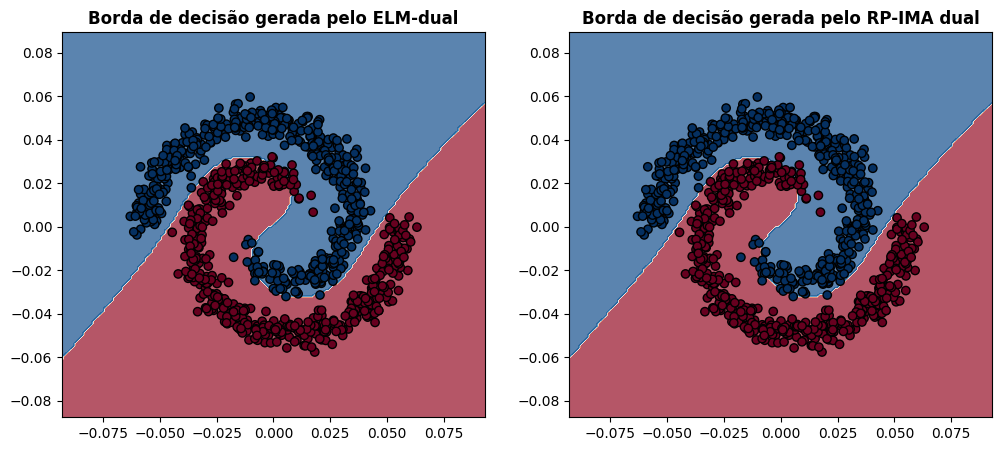

In [34]:
spirals_dataset = pd.read_csv('~/Documents/UFMG/Mastering/article/data sets/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
plots(X, y, 100, eta=0.1, reg_term=1000)

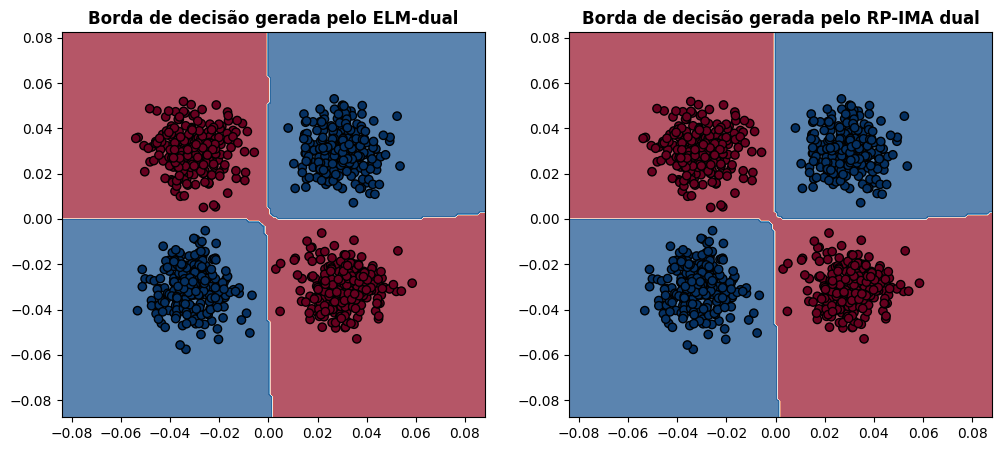

In [40]:
centers = [[-2,2],[-2,-2],[2,-2],[2,2]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6, random_state=0)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=1000)

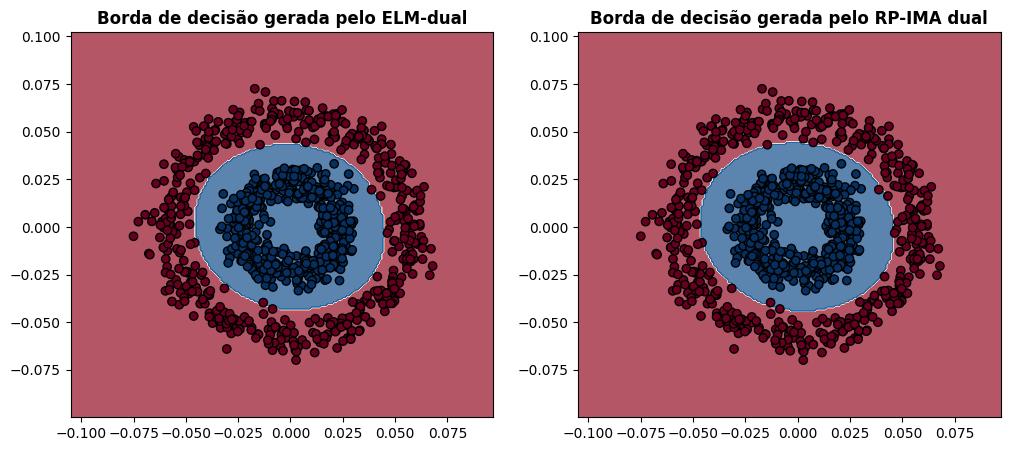

In [29]:
X, y = datasets.make_circles(n_samples=1000, factor=0.4, noise=0.07)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=1000)

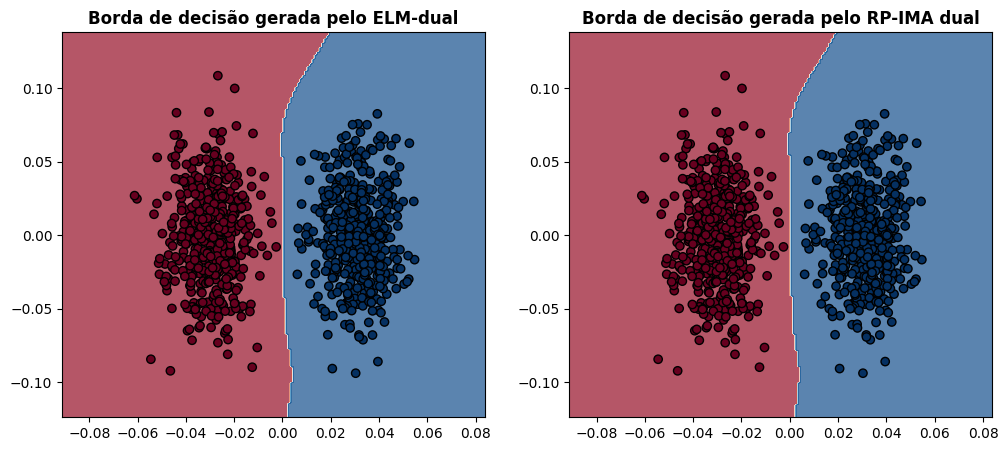

In [55]:
centers = [[-2,0],[2,0]]
centers = [[-2,0],[2,0]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6)
y[y%2!=0]=1
y[y%2==0]=-1
plots(X, y, 100, reg_term=1000)